# PIV 1068 Particles

## Process Guide

## Average Velocities method

## PIV Methodology

### **Preprocessing**

* Extract the binary files (serialTime,serialPositions, serialVelocities)
* Get the position graph in different steps to determine if there is actual movement to consider the images as candidates for the PIV frame comparison

### **Processing**

* Convert the graphs to grayscale Images
* Ensure proper particle distribution
* Use OpenPiv for aalysis

#### General information

In [1]:
# Librerías

import matplotlib.pyplot as plt
import numpy as np
from openpiv import tools, validation, filters, scaling, pyprocess
# from openpivImages import readImages, readImagesFromFolder, readImagesFromFile
import imageio
import importlib_resources
import pathlib
from PIL import Image
import os

In [2]:
# Parameters of the simulation
N=1068
box_size=91.8
h=0.0001

In [4]:
# Folder path
parent_file = "C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/"

# Recover the time, positions and velocities data files

# Time
with open(parent_file+"/quiverPlots10ps_100iterframe_damp9/serialTime.bin","rb") as f:
    dataT=np.fromfile(f,dtype=np.float64)

# Positions
with open(parent_file+"/quiverPlots10ps_100iterframe_damp9/serialPositions.bin", "rb") as f:
    dataX=np.fromfile(f,dtype=np.float64) 

# Velocities
with open(parent_file+"/quiverPlots10ps_100iterframe_damp9/serialVelocities.bin", "rb") as f:
    dataV=np.fromfile(f,dtype=np.float64)


print("Total number of float64 values in serialTime:", dataT.size)
print("Total number of float64 values in serialPositions:", dataX.size)
print("Total number of float64 values in serialVelocities:", dataV.size, "\n")

# Get the number of steps
T_steps = dataT.size
X_steps = dataX.size // (N * 2)
V_steps = dataV.size // (N * 2)

print("Number of steps in dataT: ", T_steps)
print("Number of steps in dataX: ", X_steps)
print("Number of steps in dataV: ", V_steps, "\n")

print("dataT shape should be:", (T_steps, N, 2))
print("dataX shape should be:", (X_steps, N, 2))
print("dataV shape should be:", (V_steps, N, 2), "\n")

# Number of bytes 
print("Number of bytes in dataT: ", dataT.size)
print("Number of bytes in dataX: ", dataX.size)
print("Number of bytes in dataV: ", dataV.size,"\n")

# Reshape the data in binary files  
#dataT = dataT.reshape((T_steps, N))
dataX = dataX.reshape((X_steps,N,2))
dataV = dataV.reshape((V_steps,N,2))

print("dataT new shape is : ", dataT.shape)
print("dataX new shape is : ", dataX.shape)
print("dataV new shape is : ", dataV.shape)

skip_step = 50
positions_skip = dataX[skip_step:]

# En esta parte podemos integrar la parte del promedio de Greenspan i-J

#file_total_bytes=os.path.getsize(filename)
#print(file_total_bytes)

Total number of float64 values in serialTime: 1002
Total number of float64 values in serialPositions: 2140272
Total number of float64 values in serialVelocities: 2140272 

Number of steps in dataT:  1002
Number of steps in dataX:  1002
Number of steps in dataV:  1002 

dataT shape should be: (1002, 1068, 2)
dataX shape should be: (1002, 1068, 2)
dataV shape should be: (1002, 1068, 2) 

Number of bytes in dataT:  1002
Number of bytes in dataX:  2140272
Number of bytes in dataV:  2140272 

dataT new shape is :  (1002,)
dataX new shape is :  (1002, 1068, 2)
dataV new shape is :  (1002, 1068, 2)


## Average velocities method

In [ ]:
N = 1068  # número de partículas
float_size = 8
block_size = float_size + N*2*float_size + N*2*float_size

with open('C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/average_velocitiesJ.bin', 'rb') as f:
    data = f.read()

num_blocks = len(data) // block_size

print(len(data))
print(block_size)

for i in range(num_blocks):
    offset = i * block_size
    tiempo = np.frombuffer(data[offset:offset+float_size], dtype=np.float64)[0]
    pos_actual = np.frombuffer(data[offset+float_size : offset+float_size+N*2*float_size], dtype=np.float64).reshape(N,2)
    vel_promedioJ = np.frombuffer(data[offset+float_size+N*2*float_size : offset+block_size], dtype=np.float64).reshape(N,2)
    vx = vel_promedioJ[:,0]
    vy = vel_promedioJ[:,1]

    plt.figure(figsize=(8, 8))
    plt.quiver(pos_actual[:, 0], pos_actual[:, 1], vx, vy, np.sqrt(vx**2 + vy**2), cmap='viridis')
    plt.colorbar(label='Velocidad promedio (Angstroms/ps)')
    plt.xlabel("X-axis (Angstroms)")
    plt.ylabel("Y-axis (Angstroms)")
    plt.title(f"Velocidades promedio en t={tiempo:.2f} ps, con J={}")
    plt.show()

## PIV

### Preprocessing

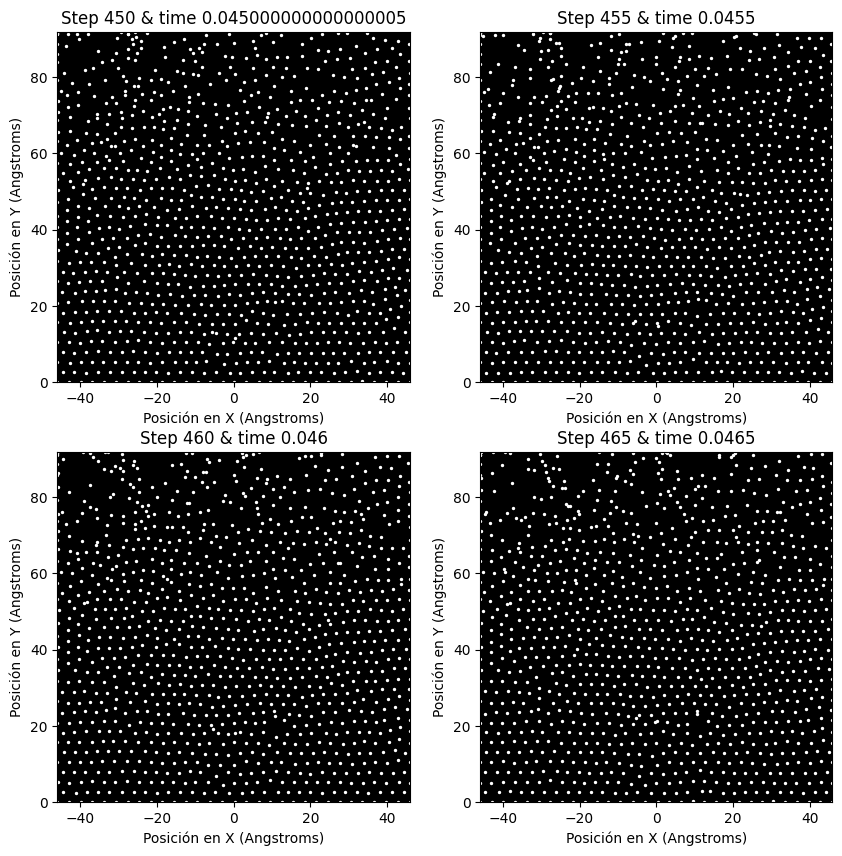

In [23]:
# Checkpoint step
step_a=450
skip_frame=5
#frames = [step_a,step_a+skip_frame]

# List of consecutive steps to evaluate
eval_steps=[step_a,step_a+skip_frame,step_a+2*skip_frame,step_a+3*skip_frame]
# Set the figure size
plt.figure(figsize=(10, 10))

#Iterate over each figure size 
for i, step in enumerate(eval_steps):
    plt.subplot(2,2,i+1)
    plt.gca().set_facecolor("black")
    plt.scatter(dataX[step,:,0],dataX[step,:,1],c="white",s=2)
    plt.title(f"Step {step} & time {step*h}")
    plt.xlim(-box_size/2, box_size/2)  # Adjust limits as needed
    plt.ylim(0, box_size)
    plt.xlabel("Posición en X (Angstroms)")
    plt.ylabel("Posición en Y (Angstroms)")

### Processing

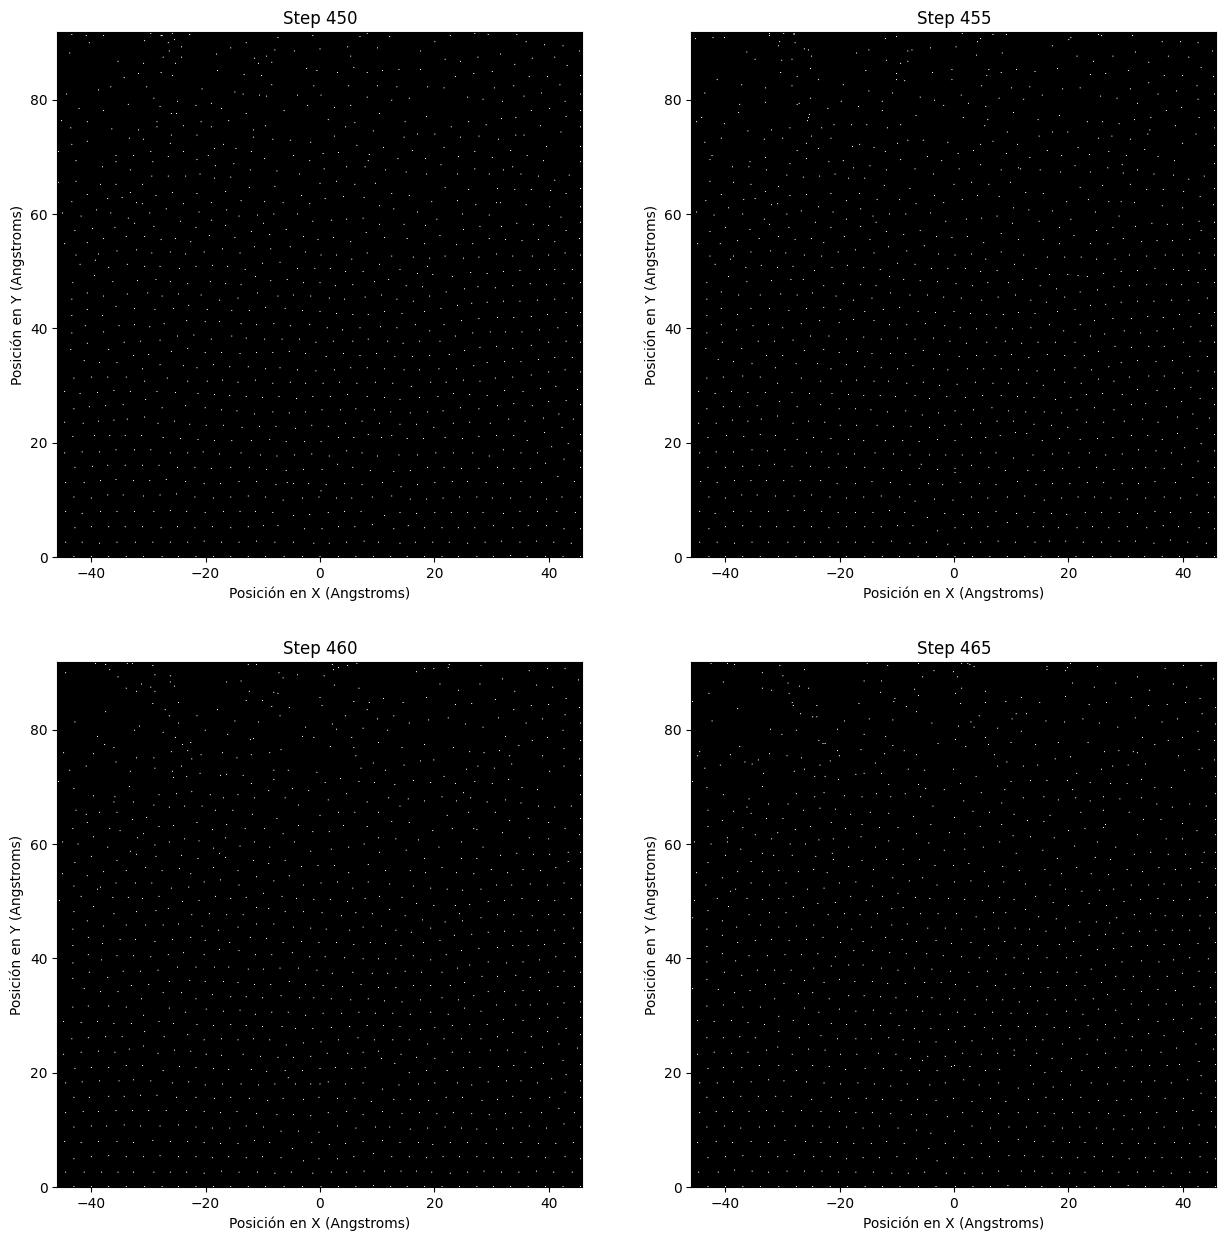

In [ ]:
# Parámetros
img_size = 512 # Tamaño de pixeles por lado
dot_size = 2

# Función para transformas las posiciones a una imagen PIV sintética
def create_piv_image(positions, box_size, img_size):
    # Creates the image array (the zeros in the image are the black background)
    img = np.zeros((img_size, img_size), dtype=np.uint8) # uint for grayscale image (unsigned integer)
    x = ((positions[:,0] + box_size/2) * (img_size-1) / box_size).astype(int)
    y = (((positions[:,1]) * (img_size-1) / box_size)).astype(int)
    img[y, x] = 255
    return img

# Selecciona dos frames
#frame1 = dataX[eval_steps[0]]
#frame2 = dataX[frames[1]]

# Genera cuatro imagenes de los 4 frames
images=[]

for i,step in enumerate(eval_steps):
    frame=dataX[step]
    image=create_piv_image(frame,box_size,img_size)
    images.append(image)

# Crea imágenes sintéticas
#img1 = create_piv_image(frame1, box_size, img_size)
#img2 = create_piv_image(frame2, box_size, img_size)

plt.figure(figsize=(15,15))

#Aquí falta poner los 
for i, image in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.gca().set_facecolor("black")
    plt.imshow(image, cmap='gray',extent=[-box_size/2, box_size/2,0,box_size],origin="lower")
    plt.title(f"Step {eval_steps[i]}")
    plt.xlim(-box_size/2, box_size/2)  # Adjust limits as needed
    plt.ylim(0, box_size)
    plt.xlabel("Posición en X (Angstroms)")
    plt.ylabel("Posición en Y (Angstroms)")

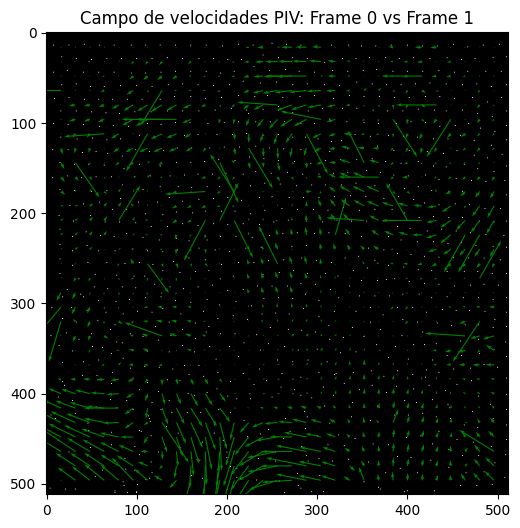

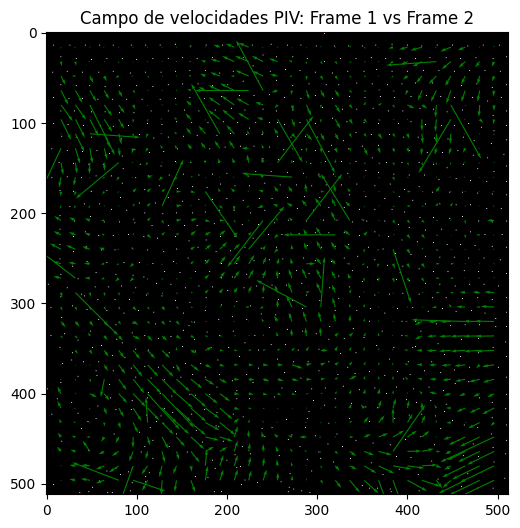

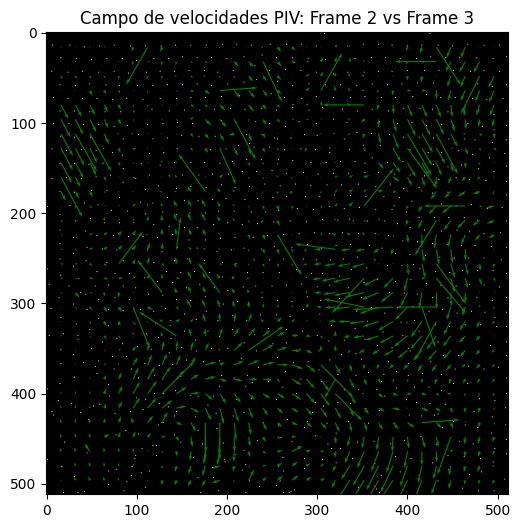

'    \nfig, axs = plt.subplots(1, 3, figsize=(18, 6))\n\nfor i in range(len(results)):\n    x, y, u, v, sig2noise = results[i]\n    img_b = images[i+1]  # The second image in each comparison\n\n    axs[i].imshow(img_b, cmap=\'gray\')\n    axs[i].quiver(x, y, u, v, color=\'g\')\n    axs[i].set_title(f\'PIV: Frame {i} vs Frame {i+1}\')\n    axs[i].set_xlim(-box_size/2, box_size/2)\n    axs[i].set_ylim(0, box_size)\n    axs[i].set_xlabel("X (Angstroms)")\n    axs[i].set_ylabel("Y (Angstroms)")\n    plt.tight_layout()\n    plt.show()\n\n'

In [83]:
# Calcula el campo de velocidades con OpenPIV
winsize = 32  # tamaño de ventana
searchsize = 32  # tamaño de búsqueda
overlap = 16  # solapamiento

results=[]

for i in range(len(eval_steps)-1):
    img_a = images[i]
    img_b = images[i+1]
    dt = eval_steps[i+1]-eval_steps[i]  # or set a constant if not available

    u, v, sig2noise = pyprocess.extended_search_area_piv(
        img_a, img_b,
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak'
    )
    x, y = pyprocess.get_coordinates(
        image_size=img_a.shape,
        search_area_size=winsize,
        overlap=overlap,
    )
    mask = validation.sig2noise_val(sig2noise, threshold = 1.3)
    u, v = filters.replace_outliers(u, v, mask, method='localmean', max_iter=3, kernel_size=2)
    x,y,u,v = scaling.uniform(x, y, u, v, scaling_factor=1.0)

    results.append((x, y, u, v, sig2noise))


    # Visualize each result
    plt.figure(figsize=(6,6))
    plt.imshow(img_b, cmap='gray')
    plt.quiver(x, y, u, v, color='g')

    plt.title(f'Campo de velocidades PIV: Frame {i} vs Frame {i+1}')
    plt.show()
    
    
"""    
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(results)):
    x, y, u, v, sig2noise = results[i]
    img_b = images[i+1]  # The second image in each comparison

    axs[i].imshow(img_b, cmap='gray')
    axs[i].quiver(x, y, u, v, color='g')
    axs[i].set_title(f'PIV: Frame {i} vs Frame {i+1}')
    axs[i].set_xlim(-box_size/2, box_size/2)
    axs[i].set_ylim(0, box_size)
    axs[i].set_xlabel("X (Angstroms)")
    axs[i].set_ylabel("Y (Angstroms)")
    plt.tight_layout()
    plt.show()

"""

[455, 460, 465]


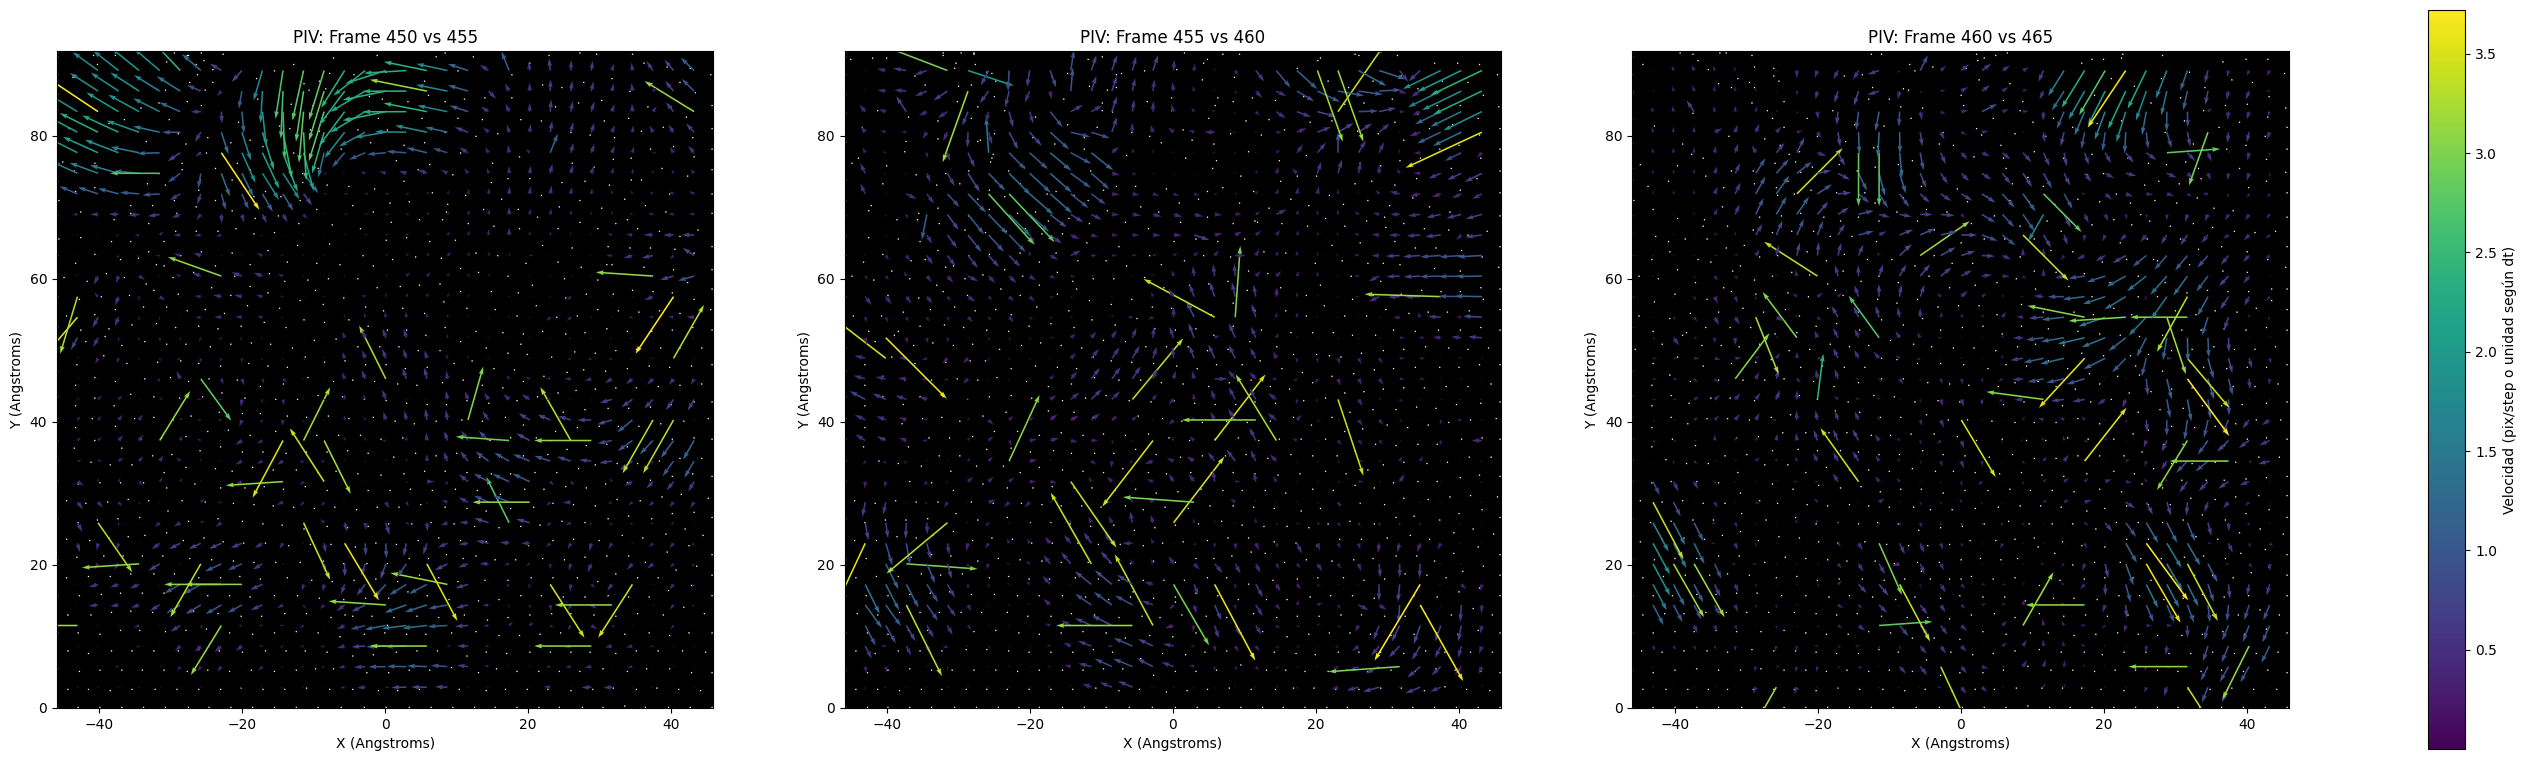

In [91]:
def pixel_to_real(x_pixel, y_pixel, box_size, img_size):
    x_real = x_pixel * box_size / (img_size - 1) - box_size / 2
    y_real = y_pixel * box_size / (img_size - 1)
    return x_real, y_real

# Aplica la conversión a los arrays x, y
#x_real, y_real = pixel_to_real(x, y, box_size, img_size)

fig, axs = plt.subplots(1, 3, figsize=(36, 12))

key_steps=eval_steps[1:]

print(key_steps)
#for i in range(len(results)):
for i,step in enumerate(key_steps):
    
    x_pix, y_pix, u, v, sig2noise = results[i]

    # convierte coordenadas de píxel a reales (desempaqueta correctamente)
    x_real, y_real = pixel_to_real(x_pix, y_pix, box_size, img_size)

    img_b = images[i]  # la segunda imagen usada en la comparación

    # dibuja la imagen con los límites en coordenadas reales (origin='lower' porque creaste imágenes con y desde 0 arriba->abajo)
    axs[i].imshow(img_b, cmap='gray', extent=[-box_size/2, box_size/2, 0, box_size], origin='lower')

    # magnitud para colorear los vectores
    mag = np.sqrt(u**2 + v**2)

    # dibuja el campo de vectores en coordenadas reales; el 5º argumento colorea por magnitud
    q = axs[i].quiver(x_real, y_real, u, v, mag, cmap='viridis', angles='xy', scale_units='xy')

    axs[i].set_title(f'PIV: Frame {step-skip_frame} vs {step}')
    axs[i].set_xlim(-box_size/2, box_size/2)
    axs[i].set_ylim(0, box_size)
    axs[i].set_xlabel("X (Angstroms)")
    axs[i].set_ylabel("Y (Angstroms)")

# deja espacio abajo para la barra de color y colócala horizontalmente debajo de las 3 imágenes

cbar = fig.colorbar(q, ax=axs.ravel().tolist(), shrink=0.8)
cbar.set_label('Velocidad (pix/step o unidad según dt)')


C:\Users\ivan_\AppData\Local\Temp\ipykernel_24272\2429799244.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.imshow(mag,cmap=plt.cm.get_cmap('coolwarm'))


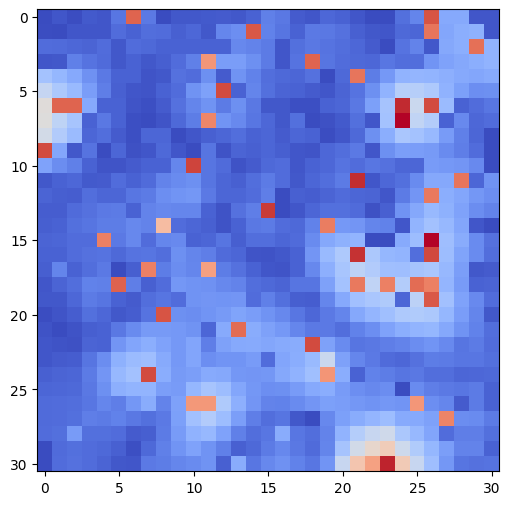

In [50]:
# Calcula la magnitud de cada vector
mag = np.empty([np.shape(x)[0], np.shape(x)[1]])
for i in range(np.shape(x)[0]):
    for j in range(np.shape(x)[1]):
        mag[i,j] = np.sqrt(u[i,j]**2 + v[i,j]**2)

# Visualiza el mapa de magnitudes
plt.figure(figsize=(6,6))
plt.imshow(mag,cmap=plt.cm.get_cmap('coolwarm')) 

### Código Residual

In [32]:
# Filtrado y validación
# Get a mask indicating which vectors have a minimum amount of S2N
#mask = validation.sig2noise_val(sig2noise, threshold = 1.3)

#u = np.where(mask, u0, 0)
#v = np.where(mask, v0, 0)

"""
# Visualiza el campo de velocidades
plt.figure(figsize=(4,4))
plt.imshow(img2, cmap='gray')
plt.quiver(x, y, u, v, color='r')
plt.title('Campo de velocidades OpenPIV antes de quitar outliers')
plt.show()
"""

# Find outlier vectors, and substitute them by an average of neighboring vectors
#u, v = filters.replace_outliers(u, v, mask, method='localmean', max_iter=3, kernel_size=2)

# print(x.shape, y.shape, u.shape, v.shape)  # All should be (N, N)

"""
# Visualiza el campo de velocidades
plt.figure(figsize=(4,4))
plt.imshow(img1, cmap='gray')
plt.quiver(x, y, u, v, color='b')
plt.title('Campo de velocidades OpenPIV')
plt.show()
"""

#x,y,u,v = scaling.uniform(x, y, u, v, scaling_factor=1.0)

# Visualiza el campo de velocidades

"""
plt.figure(figsize=(15,15))
plt.imshow(img1, cmap='gray')
plt.quiver(x, y, u, v, color='g')
plt.title('Campo de velocidades OpenPIV')
plt.show()
"""

"\nplt.figure(figsize=(15,15))\nplt.imshow(img1, cmap='gray')\nplt.quiver(x, y, u, v, color='g')\nplt.title('Campo de velocidades OpenPIV')\nplt.show()\n"

In [ ]:
""" Uncomment in case a eight set of coupled images want to be seen 
win_size = 32  # Tamaño de la ventana de correlación
img1_win = img1[0:win_size, 0:win_size].copy()
img2_win = img2[0:win_size, 0:win_size].copy()

fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img1_win, cmap=plt.cm.gray)
axs[1].imshow(img2_win, cmap=plt.cm.gray)
plt.show()
"""

In [ ]:

"""
fig = plt.imshow(img2_win - img1_win, cmap=plt.cm.gray)
plt.title('Partículas que si cambiaron entre frames')
plt.show()
"""

In [ ]:
#help(validation.sig2noise_val)

#import inspect
#print(inspect.signature(validation.sig2noise_val))
#import openpiv
#print(openpiv.__path__)